In [16]:
import gdown
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [57]:


# Ваш ID файла:
file_id = '1YE5Hlkt3pXsF3dCSmAQPrlpMqEodKFvC'
# Скачаем в текущую папку под именем dataset.csv
gdown.download(f'https://drive.google.com/uc?export=download&id={file_id}',
               'dataset.csv', quiet=False)

df = pd.read_csv('dataset.csv')
df.head()


Downloading...
From: https://drive.google.com/uc?export=download&id=1YE5Hlkt3pXsF3dCSmAQPrlpMqEodKFvC
To: /content/dataset.csv
100%|██████████| 19.3M/19.3M [00:00<00:00, 57.6MB/s]


,year,month,day,dep_time,dep_delay,arr_time,arr_delay,carrier,tailnum,flight,origin,dest,air_time,distance
0,2013,1,1,517.0,2.0,830.0,11.0,UA,N14228,1545,EWR,IAH,227.0,1400
1,2013,1,1,533.0,4.0,850.0,20.0,UA,N24211,1714,LGA,IAH,227.0,1416
2,2013,1,1,542.0,2.0,923.0,33.0,AA,N619AA,1141,JFK,MIA,160.0,1089
3,2013,1,1,544.0,-1.0,1004.0,-18.0,B6,N804JB,725,JFK,BQN,183.0,1576
4,2013,1,1,554.0,-6.0,812.0,-25.0,DL,N668DN,461,LGA,ATL,116.0,762


Количество объектов в датасете до удаления строк, в которых есть хотя бы один пропуск: 336776

Размеры после удаления: 327346

In [58]:
df = df.dropna()

In [59]:
df.isna().sum()

,0
year,0
month,0
day,0
dep_time,0
dep_delay,0
arr_time,0
arr_delay,0
carrier,0
tailnum,0
flight,0


# Задание 1

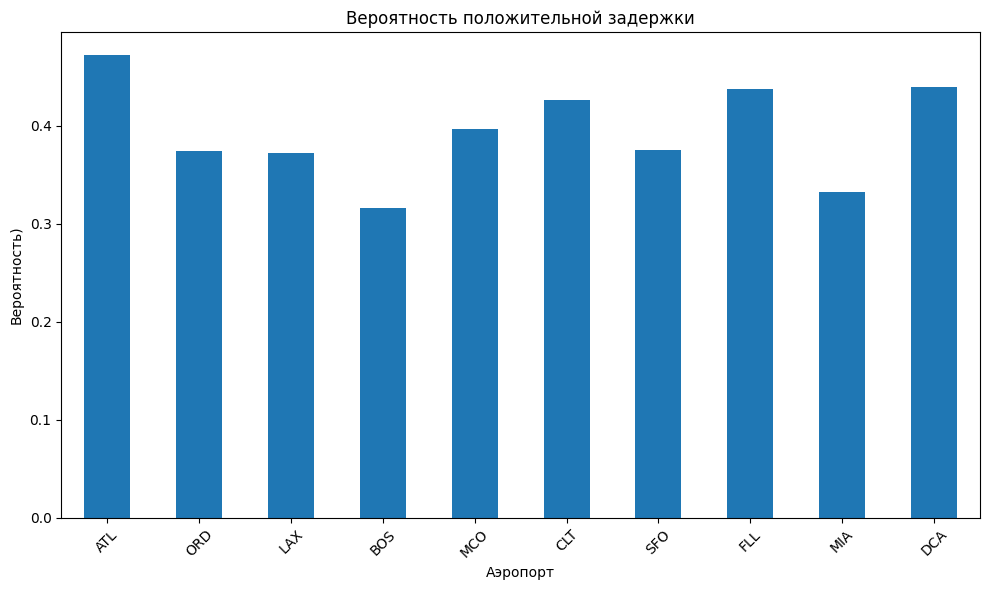

Аэропорт с наибольшей вероятностью задержки: ATL (47.19%)
Аэропорт с наименьшей вероятностью задержки:  BOS (31.57%)


In [60]:


# Отбираем рейсы из аэропортов Нью-Йорка и находим 10 аэропортов с наибольшим числом рейсов
df_nyc = df[df['origin'].isin(['JFK', 'LGA', 'EWR'])]

flight_counts = df_nyc['dest'].value_counts().nlargest(10)
top10_airports = flight_counts.index

# Расчёт вероятности arr_delay > 0 для каждого аэропорта
# суммируется список в общем [0, 0, 1, 1, 0] и делится на len([]) -> эмпирическая вероятность
prob_delay = (
    df_nyc[df_nyc['dest'].isin(top10_airports)]
    .groupby('dest')['arr_delay']
    .apply(lambda x: (x > 0).mean())
    .reindex(top10_airports)
)


plt.figure(figsize=(10, 6))
prob_delay.plot(kind='bar')
plt.xlabel('Аэропорт')
plt.ylabel('Вероятность)')
plt.title('Вероятность положительной задержки')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

max_airport = prob_delay.idxmax()
min_airport = prob_delay.idxmin()
print(f"Аэропорт с наибольшей вероятностью задержки: {max_airport} ({prob_delay[max_airport]:.2%})")
print(f"Аэропорт с наименьшей вероятностью задержки:  {min_airport} ({prob_delay[min_airport]:.2%})")


# Задание 2

Посмотрим на распределение времени полета

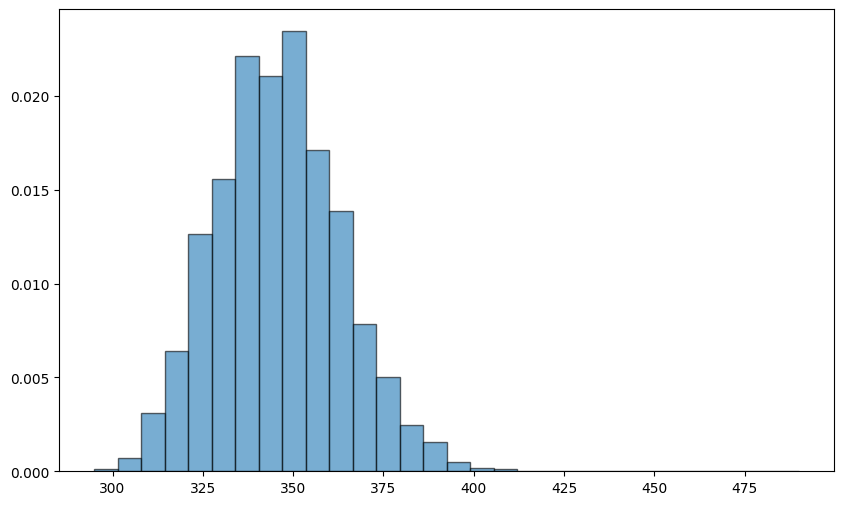

In [61]:
# Отбираем рейсы из Нью-Йорка в SFO
df_sfo = df[
    df['origin'].isin(['JFK', 'LGA', 'EWR']) &
    (df['dest'] == 'SFO')
]

air_times = df_sfo['air_time']

plt.figure(figsize=(10, 6))
plt.hist(
    air_times,
    bins=30,
    density=True,
    alpha=0.6,
    edgecolor='black'
)

# Замечание о нормальности распределения

С первого взгляда распределение действительно похоже на нормальное, однако можно рассмотреть подробнее. Посмотрим на квантиль-квантильный график


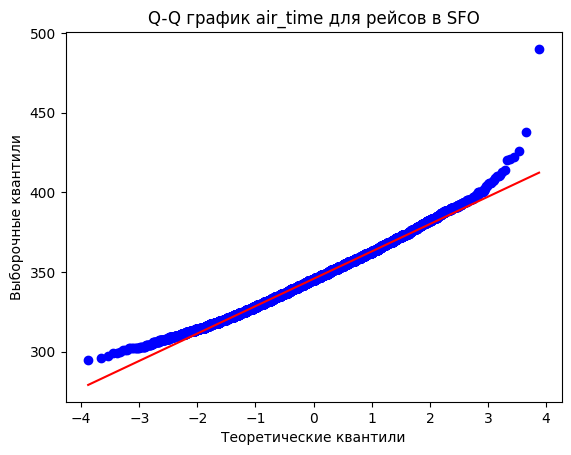

In [100]:
fig = plt.figure()
ax = fig.add_subplot(111)
stats.probplot(air_times, dist="norm", plot=ax)
ax.set_title("Q-Q график air_time для рейсов в SFO")
ax.set_xlabel("Теоретические квантили")
ax.set_ylabel("Выборочные квантили")
plt.show()

На этом Q–Q графике мы видим, что:

1. В центральной части (примерно от «теоретических» квантилей $-2$ до $+2$) точки лежат почти по красной прямой. Это говорит о том, что примерно на среднем участке выборка действительно похожа на нормальное распределение с оценёнными $\hat\mu$ и $\hat\sigma$ (мы считали на основе данных распределения).

2. В хвостах наблюдаются заметные отклонения:

   * В левом хвосте (самые маленькие времена полёта) точки лежат чуть **выше** прямой. Это означает, что на крайне малых квантилях выборка чуть «тяжелее» нормального — меньше очень коротких рейсов, чем предсказывала бы нормаль.
   * В правом хвосте (самые большие времена полёта) точки уводятся **выше** прямой всё сильнее. Это классический признак «тяжёлого правого хвоста»: слишком много длительных (или экстремально долгих) рейсов по сравнению с нормальным законом.

В итоге распределение $air\_time$ для рейсов в SFO близко к нормальному в центре, но имеет более тяжёлый правый хвост (и, в меньшей степени, левый). Также можно заметить некоторые данные, которые похожи на выбросы

Также для оценки нормальности можно провести тест Шапиро-Уилка или Колмогорова

## Оценка параметров норм. распределения и график плотности

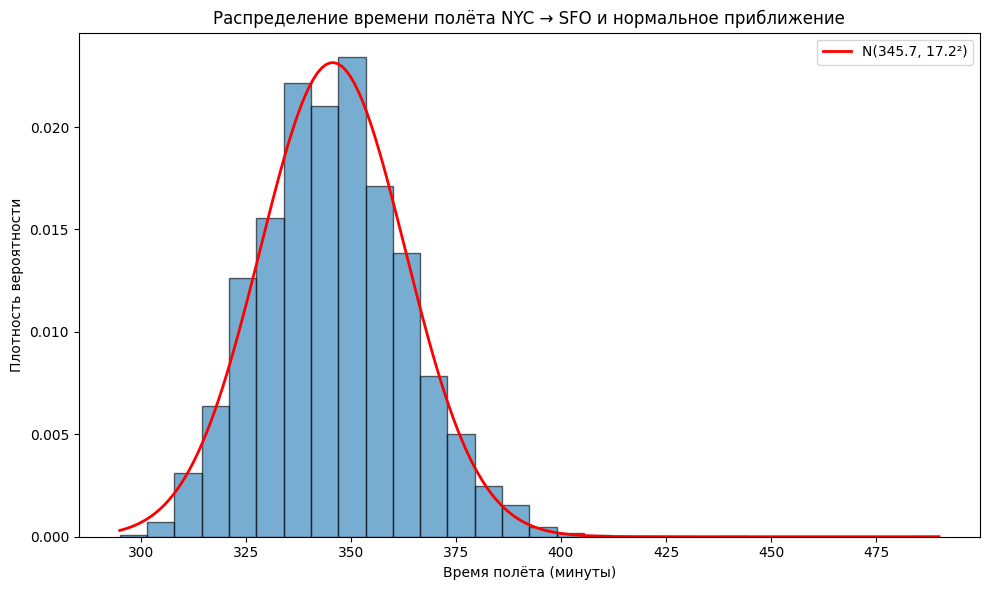

Интервал, в котором с вероятностью ≥95% лежит время полёта: [311.90 мин; 379.46 мин]


In [63]:

mu = air_times.mean()
sigma = air_times.std(ddof=0)
# или ddof = 1 для Выборочного стандартного
plt.figure(figsize=(10, 6))
plt.hist(
    air_times,
    bins=30,
    density=True,
    alpha=0.6,
    edgecolor='black'
)

x = np.linspace(air_times.min(), air_times.max(), 200)
plt.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label=f'N({mu:.1f}, {sigma:.1f}²)')

plt.xlabel('Время полёта (минуты)')
plt.ylabel('Плотность вероятности')
plt.title('Распределение времени полёта NYC → SFO и график нормального распределения')
plt.legend()
plt.tight_layout()
plt.show()

Получим интервал, в котором с вероятностью не менее 95 % окажется время полёта

In [103]:
lower, upper = stats.norm.interval(0.95, loc=mu, scale=sigma)
print(f"95% интервал: [{lower:.2f}, {upper:.2f}] минут")

95% интервал: [311.90, 379.46] минут


# Задание 3

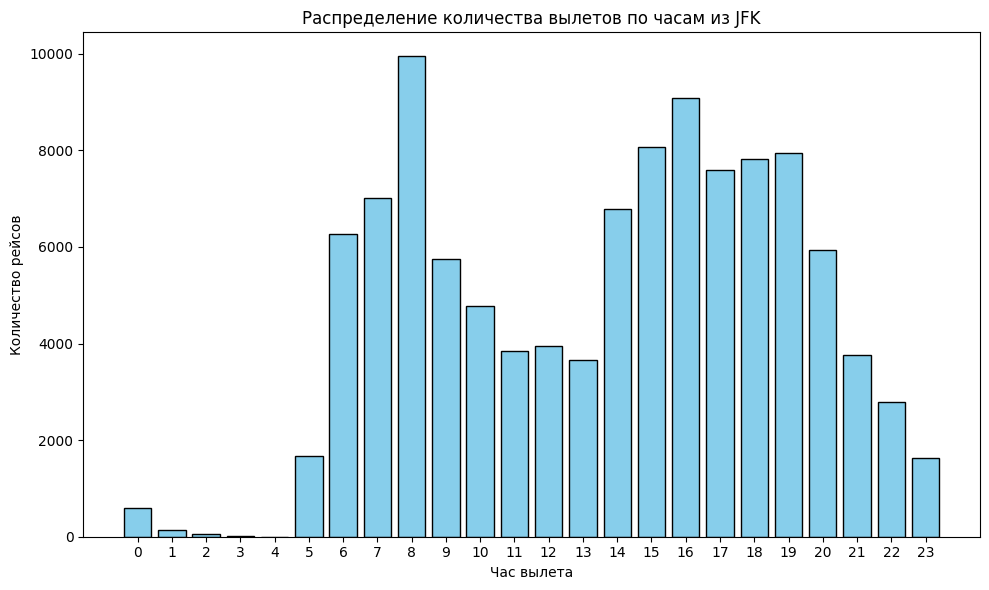

Пиковый утренний час: 8:00
Пиковый вечерний час: 16:00
Средняя задержка вылета в 8:00 — 1.04 мин
Средняя задержка вылета в 16:00 — 10.87 мин
t-тест: t = -28.21, p = 0.0000
Различие статистически значимо (p < 0.05).


In [104]:
import matplotlib.pyplot as plt
from scipy import stats

# Предполагается, что df уже загружен и очищен от пропусков
# 1. Фильтрация по JFK
df_jfk = df[df['origin'] == 'JFK'].copy()

# 2. Вычисление часа вылета
df_jfk['hour'] = df_jfk['dep_time'] // 100

# 3. Распределение вылетов по часам
hour_counts = (
    df_jfk['hour']
    .value_counts()
    .sort_index()
    .reindex(range(24), fill_value=0)
)

plt.figure(figsize=(10, 6))
plt.bar(hour_counts.index, hour_counts.values, color='skyblue', edgecolor='black')
plt.xlabel('Час вылета')
plt.ylabel('Количество рейсов')
plt.title('Распределение количества вылетов по часам из JFK')
plt.xticks(range(24))
plt.tight_layout()
plt.show()

# Поиск пиковых часов
counts_morning = hour_counts.loc[0:11]
counts_evening = hour_counts.loc[12:23]
peak_morning = counts_morning.idxmax()
peak_evening = counts_evening.idxmax()

# Средние задержки в пиковые часы
delays_morning = df_jfk.loc[df_jfk['hour'] == peak_morning, 'dep_delay']
delays_evening = df_jfk.loc[df_jfk['hour'] == peak_evening, 'dep_delay']
mean_delay_morning = delays_morning.mean()
mean_delay_evening = delays_evening.mean()

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# Воспользуемся тестом Стьюдента и проверим нулевую гипотезу о том, что утром
# и вечером среднее время задержки одинаково
t_stat, p_value = stats.ttest_ind(delays_morning, delays_evening, equal_var=False)

print(f"Пиковый утренний час: {peak_morning}:00")
print(f"Пиковый вечерний час: {peak_evening}:00")
print(f"Средняя задержка вылета в {peak_morning}:00 — {mean_delay_morning:.2f} мин")
print(f"Средняя задержка вылета в {peak_evening}:00 — {mean_delay_evening:.2f} мин")
print(f"t-тест: t = {t_stat:.2f}, p = {p_value:.4f}")
if p_value < 0.05:
    print("Различие статистически значимо (p < 0.05).")
else:
    print("Различие не статистически значимо (p ≥ 0.05).")


# Задание 4


In [65]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

## Унификация расстояния между аэропортами

**В задании нужно построить график зависимости стандартного отклонения от расстояния до аэропорта. Я решил задаться вопросом: одинаково ли расстояние между аэропортами в таблице?**

In [68]:
# группируем по месту отбытия и прибытия
group_routes = (
    df
    .groupby(['origin', 'dest'])['distance']
    .agg(nunique='nunique', dist_min='min', dist_max='max')
    .reset_index()
)

# смотрим на количество неуникальных расстояний между аэропортами (distance)
nunique_group_routes = group_routes[group_routes['nunique'] > 1]

nunique_group_routes.head()

,origin,dest,nunique,dist_min,dist_max
25,EWR,EGE,2,1725,1726
106,JFK,EGE,2,1746,1747


Как видно на примере аэропортов EWR и EGE в датасете указано разное расстояние для одних и тех же аэропортов: 1725 и 1726. Однако это различие мало. Для удобства возьмем меньшее расстояние для этих аэропортов


In [71]:
df['distance'] = (
    df
    .groupby(['origin', 'dest'])['distance']
    .transform('min')
)

## Зависимость стандартного отклонения от расстояния до аэропорта

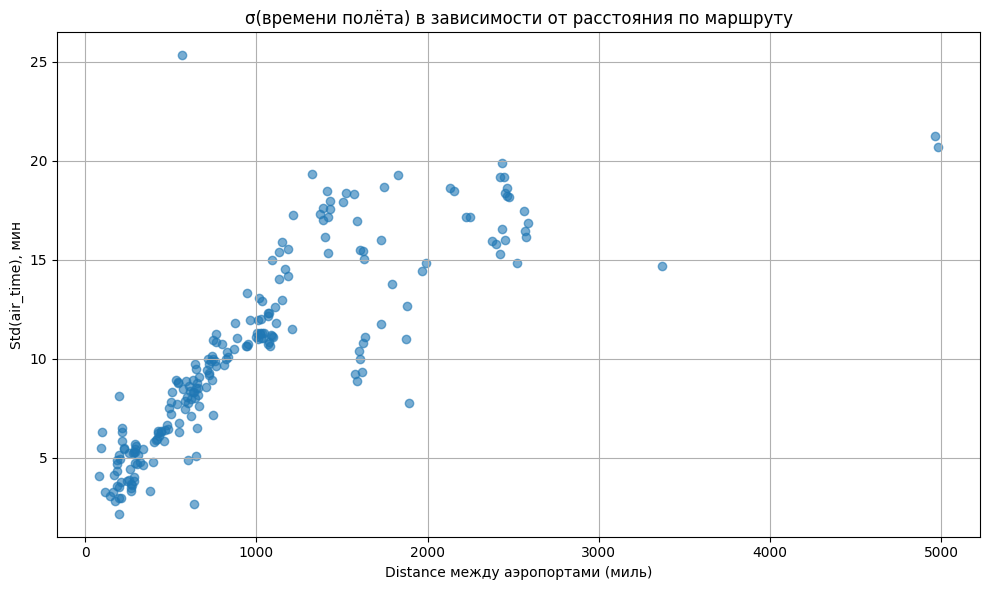

In [86]:
# Группируем по маршрутам (origin, dest)
route_stats = (
    df
    .groupby(['origin', 'dest'])
    .agg(
        std_air_time=('air_time', 'std'),
        distance=('distance', 'first')
    )
    .reset_index()
)

plt.figure(figsize=(10, 6))
plt.scatter(route_stats['distance'], route_stats['std_air_time'], alpha=0.6)

plt.xlabel('Distance между аэропортами (миль)')
plt.ylabel('Std(air_time), мин')
plt.title('σ(времени полёта) в зависимости от расстояния по маршруту')
plt.grid(True)
plt.tight_layout()
plt.show()


In [87]:
route_stats[route_stats['std_air_time'].isnull()]


,origin,dest,std_air_time,distance
89,JFK,BHM,NaN,865
120,JFK,MEM,NaN,964
151,JFK,STL,NaN,892
190,LGA,LEX,NaN,604


Проблема: получили NaN для некоторых маршрутов в колонке std_air_time. Это произошло из-за того, что был всего один такой перелет в группе. В pandas по умолчанию считается **выборочное стандартное отклонение**, где в знаменателе используется n-1. Удалим такие данные из выборки, т.к. они несут не слишком много информации, их не особо много.

In [112]:
route_stats = route_stats.dropna(subset=['std_air_time'])

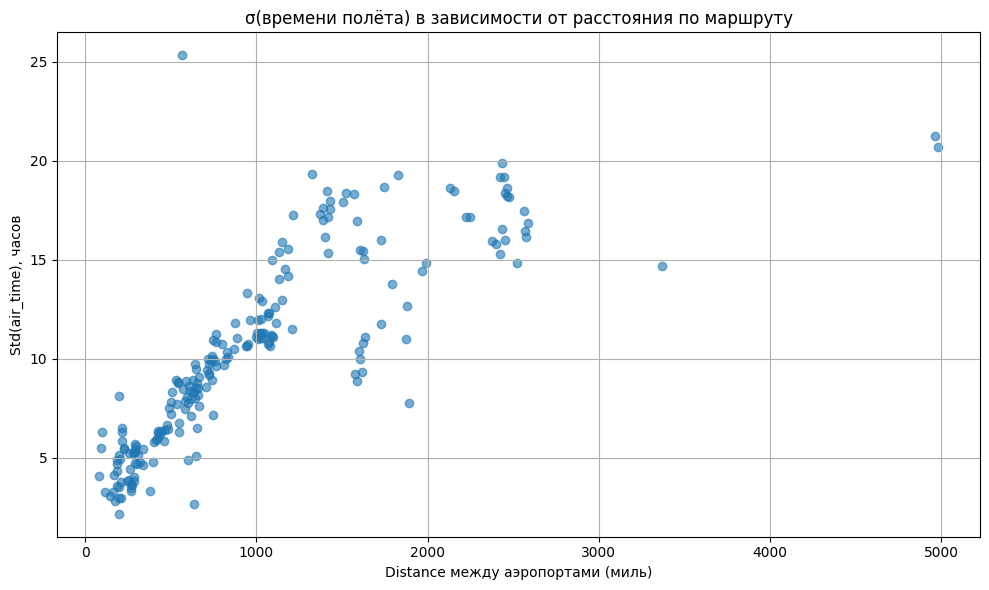

In [113]:
import pandas as pd
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.scatter(route_stats['distance'], route_stats['std_air_time'], alpha=0.6)

plt.xlabel('Distance между аэропортами (миль)')
plt.ylabel('Std(air_time), часов')
plt.title('σ(времени полёта) в зависимости от расстояния по маршруту')
plt.grid(True)
plt.tight_layout()
plt.show()


In [114]:
route_stats[route_stats['std_air_time'].isnull()]


,origin,dest,std_air_time,distance


Отлично, теперь не имеем значений NaN в колонке std_air_time

## Построение линейной регрессиии

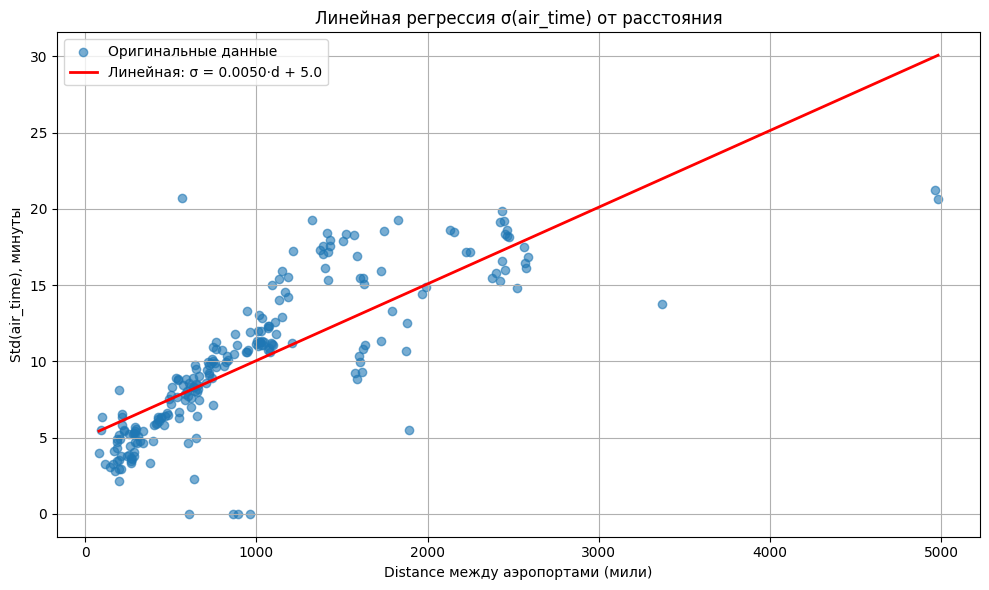

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# X и y уже заданы
X = route_stats[['distance']].values
y = route_stats['std_air_time'].values

lin_reg = LinearRegression()
lin_reg.fit(X, y)
y_pred_lin = lin_reg.predict(X)

# Сортируем для красивой линии
order = np.argsort(route_stats['distance'])
dist_sorted = route_stats['distance'].values[order]
y_lin_sorted = y_pred_lin[order]

# 1) Рисуем оригинальные точки
plt.figure(figsize=(10,6))
plt.scatter(route_stats['distance'], route_stats['std_air_time'],
            alpha=0.6, label='Оригинальные данные')

# 2) Наносим линию регрессии
plt.plot(dist_sorted, y_lin_sorted, color='red', linewidth=2,
         label=f'Линейная: σ = {lin_reg.coef_[0]:.4f}·d + {lin_reg.intercept_:.1f}')

plt.xlabel('Distance между аэропортами (мили)')
plt.ylabel('Std(air_time), минуты')
plt.title('Линейная регрессия σ(air_time) от расстояния')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


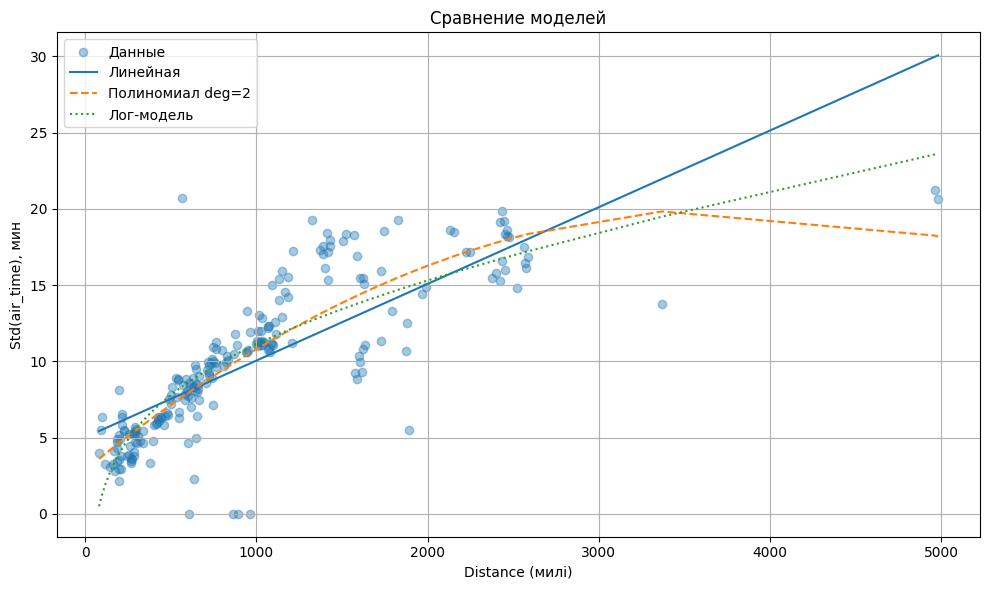

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error


X = route_stats[['distance']].values
y = route_stats['std_air_time'].values

# Линейная модель
lin_reg = LinearRegression().fit(X, y)
y_lin = lin_reg.predict(X)
r2_lin   = lin_reg.score(X, y)
rmse_lin = np.sqrt(mean_squared_error(y, y_lin))

# Полиномиальная (вторая степень)
poly2 = PolynomialFeatures(degree=2, include_bias=False)
X_p2 = poly2.fit_transform(X)
poly_reg = LinearRegression().fit(X_p2, y)
y_p2     = poly_reg.predict(X_p2)
r2_p2    = poly_reg.score(X_p2, y)
rmse_p2  = np.sqrt(mean_squared_error(y, y_p2))

# Лог-модель
X_log = np.log(route_stats['distance'].values).reshape(-1,1)
X_flog = np.hstack([X, X_log])
log_reg = LinearRegression().fit(X_flog, y)
y_log    = log_reg.predict(X_flog)
r2_log   = log_reg.score(X_flog, y)
rmse_log = np.sqrt(mean_squared_error(y, y_log))

# Результаты работы моделей
order = np.argsort(route_stats['distance'])
dist_ord = route_stats['distance'].values[order]

plt.figure(figsize=(10,6))
plt.scatter(route_stats['distance'], y, alpha=0.4, label='Данные')
plt.plot(dist_ord, y_lin[order], '-',  label='Линейная')
plt.plot(dist_ord, y_p2[order],  '--', label='Полиномиал deg=2')
plt.plot(dist_ord, y_log[order], ':',  label='Лог-модель')
plt.xlabel('Distance (милі)')
plt.ylabel('Std(air_time), мин')
plt.title('Сравнение моделей')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Теперь посмотрим на метрики


In [97]:
metrics = pd.DataFrame({
    'Model': ['Linear', 'Poly deg2', 'Log'],
    'R2':    [r2_lin,   r2_p2,     r2_log],
    'RMSE':  [rmse_lin, rmse_p2,   rmse_log]
})
metrics

,Model,R2,RMSE
0,Linear,0.626740,3.009072
1,Poly deg2,0.712180,2.642329
2,Log,0.699787,2.698618


По этим метрикам видно, что:

1. При добавлении признака d^2 линейная регрессия дала наибольший коэффициент детерминации (R² ≈ 0.712) и наименьшую ошибку (RMSE ≈ 2.64 мин).
2. При добавлении признака ln(d) линейная регрессия тоже показала хорошие результаты (R² вырос с 0.627 до 0.700, RMSE упал с 3.01 до 2.70 мин), но чуть хуже полинома.
3. Без добавления признака модель показывает самое слабое качество предсказания: она не улавливает кривизну зависимости σ(air\_time) от расстояния.

**Вывод:** в данном случае добавление полиномиального признака второго порядка существенно улучшает качество модели.

В машинном обучении необходимо делить обучающий набор данных на тренировочную и тестовую выборку, т.к. тогда мы будем больше ориентироваться на обобщающую способность модели, однако в реализации выше этого не было сделано. Не была поставлена задача обощить, а лишь аппрокимировать.  